# Prepare the environment

In [1]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [6]:
pip install torch pandas transformers tqdm scikit-learn ipywidgets

  Using cached transformers-4.41.0-py3-none-any.whl.metadata (43 kB)
  Using cached tqdm-4.66.4-py3-none-any.whl.metadata (57 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 35.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 93.2 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.1/775.1 kB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 80.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [7]:
import torch
import pandas as pd
from transformers import XLNetConfig, XLNetTokenizer, XLNetForSequenceClassification, Trainer, TrainingArguments, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset,TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm.notebook import tqdm
from transformers import DataCollatorWithPadding
import string
import pandas as pd
import tqdm.notebook as tq
import numpy as np
from IPython.utils import io
from sklearn.model_selection import train_test_split
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import XLNetTokenizer, XLNetForSequenceClassification, Trainer, TrainingArguments, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset,TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm.notebook import tqdm
from transformers import DataCollatorWithPadding

# Loading data

In [ ]:
#Reading the TSV files and verifying the number of rows
# df_tweets = pd.read_table('./distorted vs non-distorted.tsv', encoding='utf-8')
df_corpus = pd.read_csv('/kaggle/input/expertannotatedcdsdataset/train_sentences.tsv', delimiter='\t', encoding='utf-8')

print(f'Sentences count:               {df_corpus.shape[0]}')

In [45]:
df_corpus['label'].value_counts()

label
non-distorted    4024
distorted        1829
Name: count, dtype: int64

# Split data into training and test data

In [46]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_corpus["sentence"].values,
    df_corpus["encoded_label"].values,
    test_size=0.1,
    random_state=42,
    stratify=df_corpus["encoded_label"].values
)

# Generate the XLNet tokens

In [47]:
!pip install transformers SentencePiece

In [48]:
# Load XLNet tokenizer
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

In [49]:
max_seq_length = 128 # This is important as it is basically the context length and also decides how much GPU is needed.

In [50]:
# Tokenize the training set
train_input_ids = []
train_attention_masks = []
for text in tqdm(train_texts):
    encoded_dict = tokenizer.encode_plus(text,
                                         max_length=max_seq_length,
                                         add_special_tokens=True,
                                         truncation=True,
                                         padding='max_length',
                                         return_attention_mask=True,
                                         return_tensors='pt')
    train_input_ids.append(encoded_dict['input_ids'])
    train_attention_masks.append(encoded_dict['attention_mask'])

  0%|          | 0/5267 [00:00<?, ?it/s]

In [51]:
train_input_ids = torch.cat(train_input_ids, dim=0)
train_attention_masks = torch.cat(train_attention_masks, dim=0)
train_labels = torch.tensor(train_labels)

In [52]:
torch.save(train_input_ids, './train_input_ids.pt')
torch.save(train_attention_masks, './train_attention_masks.pt')
torch.save(train_labels, './train_labels.pt')

In [13]:
# Tokenize the validation set
val_input_ids = []
val_attention_masks = []
for text in tqdm(val_texts):
    encoded_dict = tokenizer.encode_plus(text,
                                         max_length=max_seq_length,
                                         add_special_tokens=True,
                                         truncation=True,
                                         padding='max_length',
                                         return_attention_mask=True,
                                         return_tensors='pt')
    val_input_ids.append(encoded_dict['input_ids'])
    val_attention_masks.append(encoded_dict['attention_mask'])

  0%|          | 0/586 [00:00<?, ?it/s]

In [14]:
val_input_ids = torch.cat(val_input_ids, dim=0)
val_attention_masks = torch.cat(val_attention_masks, dim=0)
val_labels = torch.tensor(val_labels)

In [15]:
# Save the tensors to files
torch.save(val_input_ids, './val_input_ids.pt')
torch.save(val_attention_masks, './val_attention_masks.pt')
torch.save(val_labels, './val_labels.pt')

# Prepare for training XLNet

In [17]:
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_dep

In [18]:
train_input_ids = torch.load('./train_input_ids.pt')
train_attention_masks = torch.load('./train_attention_masks.pt')
train_labels = torch.load('./train_labels.pt')

In [19]:
val_input_ids = torch.load('./val_input_ids.pt')
val_attention_masks = torch.load('./val_attention_masks.pt')
val_labels = torch.load('./val_labels.pt')

# Training the XLNet model

In [6]:
class MyDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # Get the input_ids, attention_masks, and label tensors for the given index
        input_id = self.input_ids[idx]
        attention_mask = self.attention_masks[idx]
        label = self.labels[idx]

        return {
            'input_ids': input_id,
            'attention_mask': attention_mask,
            'labels': label
        }

In [21]:
# Create a TensorDataset from the encoded texts and labels
train_dataset = MyDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = MyDataset(val_input_ids,val_attention_masks, val_labels)

In [22]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    evaluation_strategy="epoch",     # evaluate and save checkpoint every epoch
    learning_rate=2e-5,              # learning rate
    per_device_train_batch_size=32, # batch size per device during training
    per_device_eval_batch_size=32,  # batch size for evaluation
    num_train_epochs=5,              # total number of training epochs
    warmup_steps=0,                  # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,              # log after every n steps
    save_total_limit=5,              # number of total models to save
    save_strategy='epoch',
)

In [23]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [24]:
# Fine-tune the model 
# WANDB API c07df26de2fdda62ae6c5019d4fe7dfd6aad0cc2
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,0.147400,0.180592
2,0.080300,0.195293
3,0.020200,0.244298
4,0.023400,0.265989
5,0.006300,0.281111


TrainOutput(global_step=825, training_loss=0.08275071759990445, metrics={'train_runtime': 448.8445, 'train_samples_per_second': 58.673, 'train_steps_per_second': 1.838, 'total_flos': 1875580540500480.0, 'train_loss': 0.08275071759990445, 'epoch': 5.0})

In [16]:
eval_result = trainer.evaluate()


NameError: name 'trainer' is not defined

In [25]:
!nvidia-smi

Sun May 12 18:04:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0              43W / 250W |   5688MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [28]:
# Save the model
model.save_pretrained("./Final Model")

# Train from checkpoint

# Train from checkpoint

In [1]:
import torch
import pandas as pd
from transformers import XLNetConfig, XLNetTokenizer, XLNetForSequenceClassification, Trainer, TrainingArguments, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset,TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm.notebook import tqdm
from transformers import DataCollatorWithPadding
import string
import pandas as pd
import tqdm.notebook as tq
import numpy as np
from IPython.utils import io
from sklearn.model_selection import train_test_split
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import XLNetTokenizer, XLNetForSequenceClassification, Trainer, TrainingArguments, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset,TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm.notebook import tqdm
from transformers import DataCollatorWithPadding

In [2]:
import os
import re

# Set the path to the directory containing the checkpoint folders
checkpoint_dir = '/kaggle/working/results/'

# Get a list of all the checkpoint folders in the directory
checkpoint_folders = [f for f in os.listdir(checkpoint_dir) if re.match(r'checkpoint-\d+', f)]

# Sort the checkpoint folders by the numerical suffix
checkpoint_folders.sort(key=lambda x: int(x.split('-')[-1]))

# Get the latest checkpoint folder name
latest_checkpoint_folder = os.path.join(checkpoint_dir, checkpoint_folders[-1])

# Set the path to the checkpoint directory
checkpoint_path = latest_checkpoint_folder
checkpoint_path

'/kaggle/working/results/checkpoint-825'

In [ ]:
# tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
# model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=13)
# optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# training_args = TrainingArguments(
#     output_dir='./results',
#     evaluation_strategy="epoch",
#     learning_rate=2e-5,
#     per_device_train_batch_size=128,
#     per_device_eval_batch_size=128,
#     num_train_epochs=3,
#     warmup_steps=0,
#     weight_decay=0.01,
#     logging_dir='./logs',
#     logging_steps=1000,
#     save_total_limit=3,
#     save_strategy='steps',
#     save_steps=1000,
#     resume_from_checkpoint=checkpoint_path
# )

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
#     data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
# )

In [ ]:
# # Call the train method to resume training
# trainer.train(resume_from_checkpoint = True)
# # trainer.train('/content/drive/MyDrive/01 - Thesis/XLNet fine-tuning/results_backup_20230226/checkpoint-19000')

In [ ]:
# Save the model
model.save_pretrained("./")

In [4]:
model = XLNetForSequenceClassification.from_pretrained('/kaggle/working/Final Model', num_labels=2)

In [10]:
# Evaluate the model on the test set
eval_result = trainer.evaluate()

NameError: name 'trainer' is not defined

In [5]:
label_encoding = {'non-distorted':0,
'distorted':1}

In [6]:
# Input text
input_text = "I am the only one who wants to see Bolt play football."
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
# Tokenize input text
input_ids = tokenizer.encode(input_text, add_special_tokens=True, return_tensors="pt")

# Move input tensor to the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_ids = input_ids.to(device)
model = model.to(device)
# Disable gradient computation to save memory
with torch.no_grad():
    outputs = model(input_ids)

# Extract predicted label
_, predicted_label = torch.max(outputs[0], dim=1)

print("Predicted label:", predicted_label.item())

Predicted label: 1


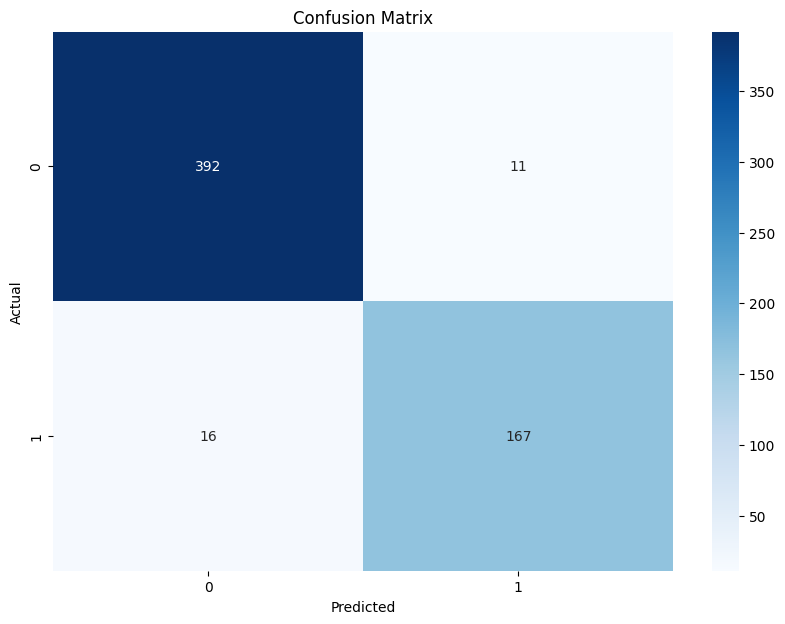

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       403
           1       0.94      0.91      0.93       183

    accuracy                           0.95       586
   macro avg       0.95      0.94      0.95       586
weighted avg       0.95      0.95      0.95       586



In [17]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load the saved tensors
val_input_ids = torch.load('./val_input_ids.pt')
val_attention_masks = torch.load('./val_attention_masks.pt')
val_labels = torch.load('./val_labels.pt')

# Move tensors and model to the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
val_input_ids = val_input_ids.to(device)
val_attention_masks = val_attention_masks.to(device)
val_labels = val_labels.to(device)
model = model.to(device)

# Set the model to evaluation mode
model.eval()

# Disable gradient computation to save memory
with torch.no_grad():
    outputs = model(val_input_ids, attention_mask=val_attention_masks)
    logits = outputs[0]

# Get the predicted labels
predicted_labels = torch.argmax(logits, dim=1)

# Move predicted labels and true labels to CPU for evaluation
predicted_labels = predicted_labels.cpu().numpy()
true_labels = val_labels.cpu().numpy()

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(true_labels, predicted_labels))


In [7]:
# import torch

# checkpoint = torch.load(checkpoint_path, map_location=torch.device("cpu"))

# print(checkpoint.keys())


IsADirectoryError: [Errno 21] Is a directory: '/kaggle/working/results/checkpoint-825'

In [18]:
import pandas as pd

# Specify the path to the CSV file
file_path = r"/kaggle/input/expertannotatedcdsdataset/Annotated_data.csv"
# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)
# Keep only the desired columns
df = df[["Id_Number", "Distorted part","Patient Question", "Dominant Distortion", "Secondary Distortion (Optional)"]]
df.shape

(2530, 5)

In [19]:
df['Dominant Distortion'].value_counts()

Dominant Distortion
No Distortion              933
Overgeneralization         239
Mind Reading               239
Magnification              195
Labeling                   165
Personalization            153
Fortune-telling            143
Emotional Reasoning        134
Mental filter              122
Should statements          107
All-or-nothing thinking    100
Name: count, dtype: int64

In [20]:
df.loc[df['Dominant Distortion'] == 'No Distortion', 'Distorted part'] = df['Patient Question']

print(df)

      Id_Number                                     Distorted part  \
0          4500  The voice are always fimilar (someone she know...   
1          4501  I feel trapped inside my disgusting self and l...   
2          4502   So I’ve been dating on and off this guy for a...   
3          4503  My parents got divorced in 2004. My mother has...   
4          4504  I refused to go because I didn’t know if it wa...   
...         ...                                                ...   
2525       2562  I’m a 21 year old female. I spent most of my l...   
2526       2563  Now I am at university my peers around me all ...   
2527       2564  He claims he’s severely depressed and has outb...   
2528       2565  From the U.S.: I am a 21 year old woman who ha...   
2529       2568  I recently moved out on my ex-roommate because...   

                                       Patient Question Dominant Distortion  \
0     Hello, I have a beautiful,smart,outgoing and a...     Personalization   
1

In [21]:
all_distortions = pd.concat([df['Dominant Distortion']])

distortion_to_id = {distortion: i for i, distortion in enumerate(all_distortions.dropna().unique())}
distortion_to_id

{'Personalization': 0,
 'Labeling': 1,
 'No Distortion': 2,
 'Fortune-telling': 3,
 'Magnification': 4,
 'Mind Reading': 5,
 'All-or-nothing thinking': 6,
 'Overgeneralization': 7,
 'Mental filter': 8,
 'Emotional Reasoning': 9,
 'Should statements': 10}

In [22]:
df['Dominant Distortion Encoded'] = df['Dominant Distortion'].map(distortion_to_id).astype(pd.Int64Dtype())
df['Dominant Distortion Encoded'].value_counts()

Dominant Distortion Encoded
2     933
7     239
5     239
4     195
1     165
0     153
3     143
9     134
8     122
10    107
6     100
Name: count, dtype: Int64

In [23]:
num_labels = len(distortion_to_id)
df = df.dropna(subset=["Distorted part", "Dominant Distortion Encoded"])

In [24]:
df['Dominant Distortion Encoded'].value_counts()

Dominant Distortion Encoded
2     933
7     239
5     239
4     195
1     165
0     153
3     143
9     134
8     122
10    107
6     100
Name: count, dtype: Int64

# Split data into training and test data

In [25]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["Distorted part"].values,
    df["Dominant Distortion Encoded"].values,
    test_size=0.1,
    random_state=42,
    stratify=df["Dominant Distortion Encoded"].values
)

# Generate the XLNet tokens

In [26]:
# Load XLNet tokenizer
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

In [42]:
max_seq_length = 64 # This is important as it is basically the context length and also decides how much GPU is needed.

In [43]:
# Tokenize the training set
train_input_ids = []
train_attention_masks = []
for text in tqdm(train_texts):
    encoded_dict = tokenizer.encode_plus(text,
                                         max_length=max_seq_length,
                                         add_special_tokens=True,
                                         truncation=True,
                                         padding='max_length',
                                         return_attention_mask=True,
                                         return_tensors='pt')
    train_input_ids.append(encoded_dict['input_ids'])
    train_attention_masks.append(encoded_dict['attention_mask'])

  0%|          | 0/2277 [00:00<?, ?it/s]

In [44]:
train_input_ids = torch.cat(train_input_ids, dim=0)
train_attention_masks = torch.cat(train_attention_masks, dim=0)
train_labels = torch.tensor(train_labels)

/tmp/ipykernel_34/3664121389.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels)


In [45]:
torch.save(train_input_ids, './train_input_ids_10lbls.pt')
torch.save(train_attention_masks, './train_attention_masks_10lbls.pt')
torch.save(train_labels, './train_labels_10lbls.pt')

In [46]:
# Tokenize the validation set
val_input_ids = []
val_attention_masks = []
for text in tqdm(val_texts):
    encoded_dict = tokenizer.encode_plus(text,
                                         max_length=max_seq_length,
                                         add_special_tokens=True,
                                         truncation=True,
                                         padding='max_length',
                                         return_attention_mask=True,
                                         return_tensors='pt')
    val_input_ids.append(encoded_dict['input_ids'])
    val_attention_masks.append(encoded_dict['attention_mask'])

  0%|          | 0/253 [00:00<?, ?it/s]

In [47]:
val_input_ids = torch.cat(val_input_ids, dim=0)
val_attention_masks = torch.cat(val_attention_masks, dim=0)
val_labels = torch.tensor(val_labels)

/tmp/ipykernel_34/2405050284.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels = torch.tensor(val_labels)


In [48]:
# Save the tensors to files
torch.save(val_input_ids, './val_input_ids_10lbls.pt')
torch.save(val_attention_masks, './val_attention_masks_10lbls.pt')
torch.save(val_labels, './val_labels_10lbls.pt')

# Load checkpoints here

In [49]:
import torch
import pandas as pd
from transformers import XLNetConfig, XLNetTokenizer, XLNetForSequenceClassification, Trainer, TrainingArguments, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset,TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm.notebook import tqdm
from transformers import DataCollatorWithPadding
import string
import pandas as pd
import tqdm.notebook as tq
import numpy as np
from IPython.utils import io
from sklearn.model_selection import train_test_split
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import XLNetTokenizer, XLNetForSequenceClassification, Trainer, TrainingArguments, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset,TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm.notebook import tqdm
from transformers import DataCollatorWithPadding

In [50]:
import os
import re

# Set the path to the directory containing the checkpoint folders
checkpoint_dir = '/kaggle/working/results/'

# Get a list of all the checkpoint folders in the directory
checkpoint_folders = [f for f in os.listdir(checkpoint_dir) if re.match(r'checkpoint-\d+', f)]

# Sort the checkpoint folders by the numerical suffix
checkpoint_folders.sort(key=lambda x: int(x.split('-')[-1]))

# Get the latest checkpoint folder name
latest_checkpoint_folder = os.path.join(checkpoint_dir, checkpoint_folders[-1])

# Set the path to the checkpoint directory
checkpoint_path = latest_checkpoint_folder
checkpoint_path

'/kaggle/working/results/checkpoint-825'

In [51]:
train_input_ids = torch.load('./train_input_ids_10lbls.pt')
train_attention_masks = torch.load('./train_attention_masks_10lbls.pt')
train_labels = torch.load('./train_labels_10lbls.pt')

In [52]:
val_input_ids = torch.load('./val_input_ids_10lbls.pt')
val_attention_masks = torch.load('./val_attention_masks_10lbls.pt')
val_labels = torch.load('./val_labels_10lbls.pt')

# Training the XLNet model

In [53]:
class MyDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # Get the input_ids, attention_masks, and label tensors for the given index
        input_id = self.input_ids[idx]
        attention_mask = self.attention_masks[idx]
        label = self.labels[idx]

        return {
            'input_ids': input_id,
            'attention_mask': attention_mask,
            'labels': label
        }

In [54]:
# Create a TensorDataset from the encoded texts and labels
train_dataset = MyDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = MyDataset(val_input_ids,val_attention_masks, val_labels)

In [55]:
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels = num_labels)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=3,
    warmup_steps=0,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=1000,
    save_total_limit=3,
    save_strategy='steps',
    save_steps=1000,
    resume_from_checkpoint=checkpoint_path
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderCo

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 15.89 GiB of which 22.12 MiB is free. Process 3003 has 15.87 GiB memory in use. Of the allocated memory 15.51 GiB is allocated by PyTorch, and 65.01 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [58]:
!nvidia-smi

Fri May 17 17:26:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              30W / 250W |  16254MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Fine-tune the model 
# WANDB API c07df26de2fdda62ae6c5019d4fe7dfd6aad0cc2
trainer.train()
eval_result = trainer.evaluate()


In [14]:
import numpy as np

# Assuming 'train_labels' and 'val_labels' are your label tensors

# Convert to numpy arrays if they are not already
train_labels_np = train_labels.numpy() if isinstance(train_labels, torch.Tensor) else np.array(train_labels)
val_labels_np = val_labels.numpy() if isinstance(val_labels, torch.Tensor) else np.array(val_labels)

# Check the range of the labels
n_classes = len(np.unique(train_labels_np))
assert train_labels_np.min() >= 0 and train_labels_np.max() < n_classes, "Train labels are out of range"
assert val_labels_np.min() >= 0 and val_labels_np.max() < n_classes, "Validation labels are out of range"


AssertionError: Train labels are out of range

In [15]:
# Inspect unique label values
print("Unique train labels:", np.unique(train_labels_np))
print("Unique validation labels:", np.unique(val_labels_np))


Unique train labels: [ 0  1  3  4  5  6  7  8  9 10]
Unique validation labels: [ 0  1  3  4  5  6  7  8  9 10]
